In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import sklearn.metrics as skm
from helper_functions import NUM2STR, STR2NUM
from helper_functions import mean_std, median_iqr, perc_transition

In [2]:
wdir = "output/cv"
wdir_demo = "output/demographics/"

In [3]:
# Choose model (set in config) -------------------
model = "eeg+eog+emg+demo"

df = pd.read_parquet(wdir + "/cv_loo_nsrr_shhs.parquet")
# df['subj'] = df['subj'].astype(str)
df_demo = pd.read_csv(wdir_demo + "shhs_demo.csv").set_index('subj')

In [4]:
df_demo

,age,male,bmi,ahi,ethnicity,set,hypertension
subj,,,,,,,
200077,41.0,1,23.388687,9.738220,caucasian,excluded,0.0
200078,54.0,1,30.211833,19.685039,caucasian,excluded,1.0
200079,56.0,0,35.451050,26.000000,other,excluded,0.0
200080,54.0,1,32.645673,12.450000,caucasian,excluded,0.0
200081,40.0,0,31.644286,2.632794,caucasian,excluded,0.0
...,...,...,...,...,...,...,...
205798,59.0,1,30.804282,13.350000,caucasian,training,1.0
205799,54.0,0,33.059629,NaN,caucasian,excluded,0.0
205800,66.0,1,26.418929,56.115108,caucasian,excluded,1.0


In [5]:
# Per each night
df_scores = []

labels = ['N1', 'N2', 'N3', 'R', 'W']

for sub in tqdm(df['subj'].unique(), leave=False):
    df_sub = df[df['subj'] == sub]
    yt = df_sub['y_true']
    yp = df_sub['y_pred']
    n = yt.shape[0]

    sub_scores = {
        # Accuracy
        'accuracy': 100 * skm.accuracy_score(yt, yp),
        'kappa': 100 * skm.cohen_kappa_score(yt, yp, labels=labels),
        'mcc': 100 * skm.matthews_corrcoef(yt, yp),
        'f1_macro': 100 * skm.f1_score(yt, yp, labels=labels, average='macro', zero_division=1),
        # % Transitions
        'dur_hours': (yt.size / 2) / 60,
        'perc_trans_true': perc_transition(yt),
        'perc_trans_pred': perc_transition(yp),
        # Confidence
        'avg_confidence': 100 * df_sub['confidence'].mean()
    }

    # F1 for each stage
    f1 = 100 * skm.f1_score(yt, yp, average=None, labels=labels, zero_division=1)
    for f, l in zip(f1, labels):
        sub_scores['f1_' + l] = f
        
    # In the case of an error, is the second-highest probability typically the correct one?
    error = (yp != yt).to_numpy()
    sub_scores['accuracy_second'] = 100 * skm.accuracy_score(yt[error], df_sub['y_pred_second'][error])

    # Proportion of each stage (NaN = 0)
    prop_true = (yt.value_counts() / n).add_prefix('perc_').add_suffix('_true')
    prop_pred = (yp.value_counts() / n).add_prefix('perc_').add_suffix('_pred')
    sub_scores.update(prop_true.to_dict())
    sub_scores.update(prop_pred.to_dict())

    # Append to main dataframe
    df_scores.append(pd.DataFrame(sub_scores, index=[sub]))


df_scores = pd.concat(df_scores)
df_scores.sort_index(axis=1, inplace=True)
df_scores.index.name = 'subj'

# Join with demographics
df_scores = df_scores.join(df_demo, how="left")

In [6]:
cmap = list(sns.color_palette("Blues", n_colors=10, as_cmap=False, desat=1))
color_pred = cmap[-1]
color_ref = "tab:orange"
cmap_stages = ['#99d7f1', '#009DDC', 'xkcd:twilight blue', 'xkcd:rich purple', 'xkcd:sunflower']

In [7]:
df_scores

,accuracy,accuracy_second,avg_confidence,dur_hours,f1_N1,f1_N2,f1_N3,f1_R,f1_W,f1_macro,...,perc_W_true,perc_trans_pred,perc_trans_true,age,male,bmi,ahi,ethnicity,set,hypertension
subj,,,,,,,,,,,,,,,,,,,,,
200207,90.418118,19.090909,93.626706,9.566667,6.451613,91.340782,53.846154,83.911672,94.527363,66.015517,...,0.530488,10.714286,5.662021,64.0,1,27.494331,5.555556,caucasian,testing,0.0
200383,84.227382,17.766497,92.624837,10.408333,0.000000,76.729560,87.552448,77.675841,92.578616,66.907293,...,0.317054,12.890312,10.168135,42.0,0,26.161896,29.508197,caucasian,testing,0.0
200467,88.176727,5.789474,96.851092,13.391667,27.906977,92.307692,88.505747,59.259259,92.796370,72.155209,...,0.518357,9.209708,6.098320,45.0,0,23.021535,1.240310,caucasian,testing,0.0
200495,85.730858,20.325203,93.719933,7.183333,23.076923,89.162562,72.289157,78.571429,92.366412,71.093296,...,0.299304,14.965197,13.457077,52.0,1,23.842221,27.508306,caucasian,testing,1.0
200499,84.035088,15.934066,92.882680,9.500000,26.923077,90.316004,14.285714,74.404762,89.073634,59.000638,...,0.342105,12.719298,8.771930,67.0,1,24.871185,25.600000,caucasian,testing,1.0
200692,91.006098,17.796610,92.437770,10.933333,53.846154,92.191910,78.082192,91.558442,95.314058,82.198551,...,0.387195,13.185976,13.109756,63.0,1,24.293878,36.957606,caucasian,testing,0.0
200928,85.606061,32.631579,88.273773,11.000000,26.923077,91.359880,66.666667,81.600000,89.117984,71.133521,...,0.308333,16.515152,12.954545,62.0,0,42.979571,60.656455,caucasian,testing,1.0
201083,91.317593,14.912281,93.471392,10.941667,36.842105,93.410214,86.538462,94.619666,92.699491,80.821988,...,0.234577,12.718964,11.348058,40.0,1,28.596757,23.021869,caucasian,testing,0.0
201116,94.152431,21.348315,94.543006,12.683333,43.902439,94.937759,60.000000,93.768546,96.737589,77.869267,...,0.463863,8.081472,7.095926,47.0,1,36.138114,87.272727,caucasian,testing,0.0


<ipython-input-8-9929a514eed9>:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


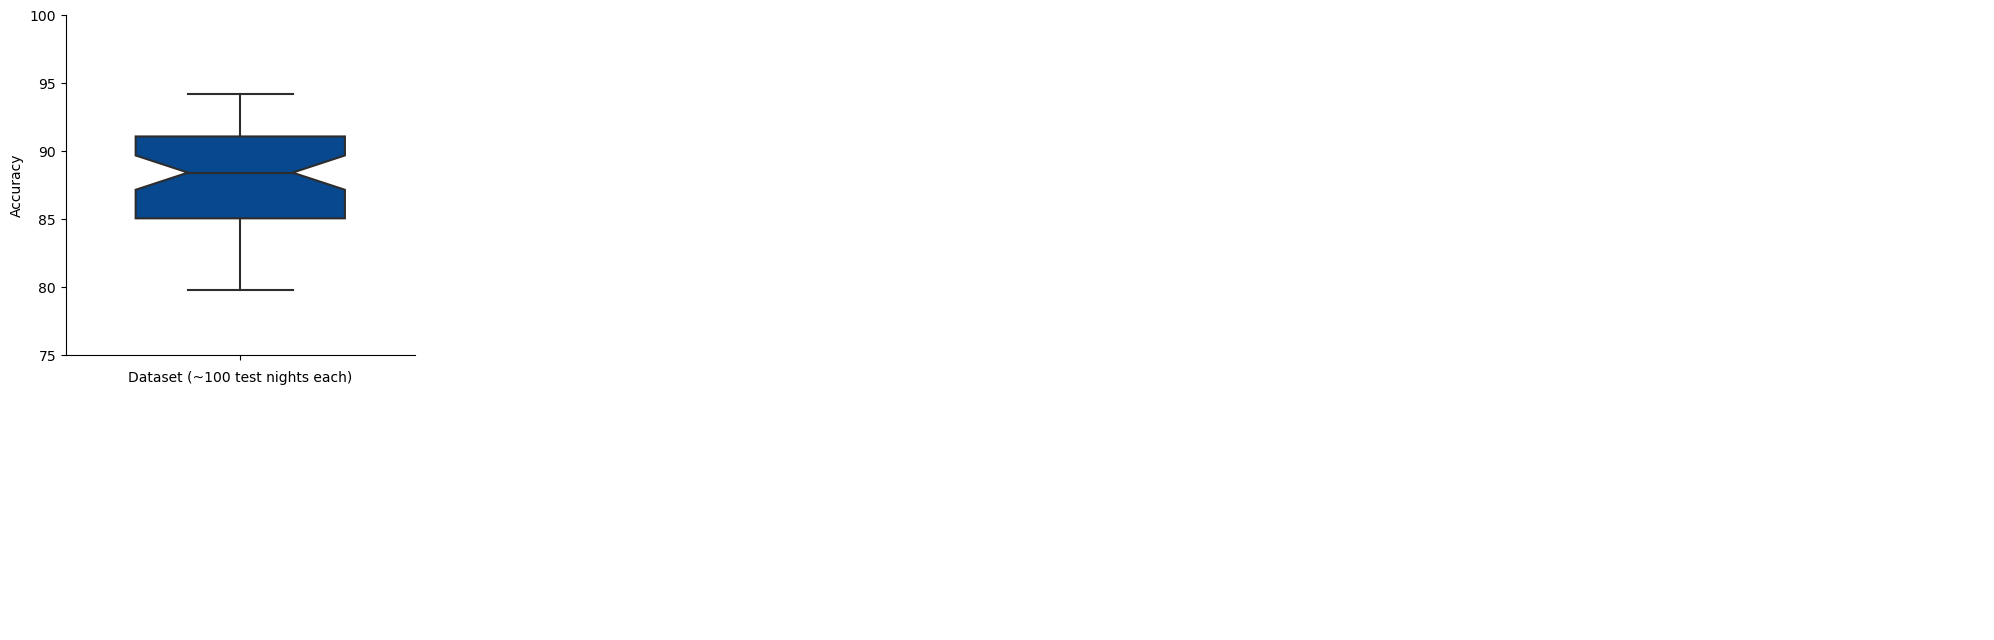

In [8]:
# Boxplot of accuracy
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)
# order = df_scores['accuracy'].median().sort_values(ascending=False).index

ax1 = sns.boxplot(data=df_scores.reset_index(), y='accuracy', color=color_pred, saturation=1, 
                  fliersize=0, width=0.6, notch=True, linewidth=1.5)
                  # boxprops=dict(edgecolor="k"))

# plt.title("Performance on testing set (n=%i)" % df_scores.shape[0])
plt.xlabel("Dataset (~100 test nights each)")
plt.ylabel("Accuracy")
plt.ylim(75, 100)

ax.annotate("Accuracy (median): %.2f\nKappa (median): %.2f" % 
            (df_scores['accuracy'].median(), df_scores['kappa'].median()),
            xy=(5, 55), ha="right", fontstyle="italic", fontweight="semibold")

sns.despine()
plt.tight_layout()
plt.show()#savefig(outdir + "cv_boxplot_accuracy_datasets.png", dpi=300, bbox_inches="tight")

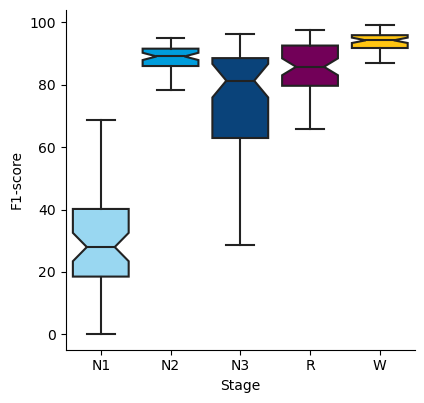

In [9]:
df_f1 = df_scores[['f1_N1', 'f1_N2', 'f1_N3', 'f1_R', 'f1_W']].copy()
df_f1.columns = df_f1.columns.str.split('_').str.get(1)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)
sns.boxplot(data=df_f1, palette=cmap_stages, fliersize=0, ax=ax, saturation=1, notch=True)
plt.xlabel("Stage")
plt.ylabel("F1-score")
sns.despine()

### Confustion Matrix

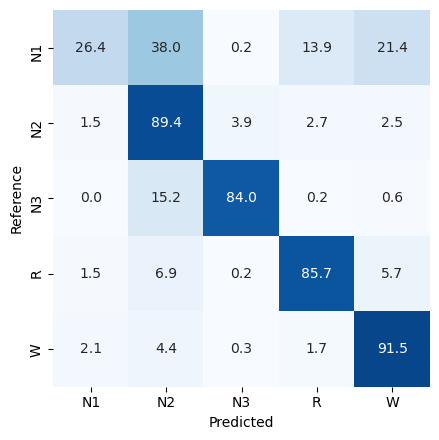

In [10]:

cm = 100 * skm.confusion_matrix(df['y_true'], df['y_pred'], labels=labels, normalize="true")
cm = pd.DataFrame(cm, index=labels, columns=labels)

# Plot
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(4.5, 4.5))
sns.heatmap(cm, annot=True, vmin=0, vmax=100, cmap="Blues", square=True, cbar=False, fmt=".1f")
plt.ylabel("Reference")
plt.xlabel("Predicted")
# plt.title("Recall", y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()#plt.savefig(outdir + "cv_confusion_recall.png", dpi=300, bbox_inches="tight")

### 

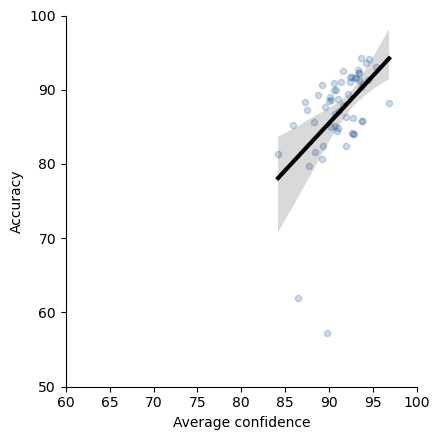

In [15]:
# corr_conf = df_scores.pairwise_corr(['avg_confidence', 'accuracy']).round(3)
# display(corr_conf)

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5), dpi=100)
sns.regplot(data=df_scores, x="avg_confidence", y="accuracy", truncate=True, order=1,
            scatter_kws={"s": 20, "alpha": .2, "lw": 1},
            line_kws={"color": "k", "lw": 3}, 
            color=color_pred, ax=ax)
plt.xlim(60, 100)
plt.ylim(50, 100)
plt.xlabel("Average confidence")
plt.ylabel("Accuracy")

# plt.annotate("r=%.2f" % corr_conf.loc[0, 'r'], (0.6, 0.1), xycoords="axes fraction", fontstyle="italic")
sns.despine()
plt.tight_layout()
plt.show()#plt.savefig(outdir + "cv_accuracy_confidence.png", dpi=300, bbox_inches="tight")

### Feature Importance

In [19]:
dic_features = {
    "eog_abspow": "EOG: Absolute power",
    "eeg_petrosian": "EEG: Petrosian fractal dimension",
    "eeg_abspow": "EEG: Absolute power",
    "eeg_beta": "EEG: Beta power",
    "eeg_petrosian_c7min_norm": "EEG: Petrosian fractal dimension (7.5 min)",
    "eeg_fdelta": "EEG: Fast delta power",
    "eog_fdelta_c7min_norm": "EOG: Fast delta power (7.5 min)",
    "eeg_db": "EEG: Delta/beta power ratio",
    "eeg_perm": "EEG: Permutation entropy",
    "eog_petrosian": "EOG: Petrosian fractal dimension",
    "eeg_abspow_c7min_norm": "EEG: Absolute power (7.5 min)",
    "eog_std": "EOG: Standard deviation",
    "eeg_theta_c7min_norm": "EEG: Theta power (7.5 min)",
    "eog_skew_c7min_norm": "EOG: Skewness (7.5 min)",
    "eog_higuchi_c7min_norm": "EOG: Higuchi fractal dimension (7.5 min)",
    "eog_hcomp_c7min_norm": "EOG: Hjorth complexity (7.5 min)",
    "eeg_beta_p2min_norm": "EEG: Beta power (2 min)",
    "emg_std_p2min_norm": "EMG: Standard deviation (2 min)",
    "eeg_higuchi": "EEG: Higuchi fractal dimension",
    "time_norm": "Time elapsed from beginning of recording (norm.)"
}

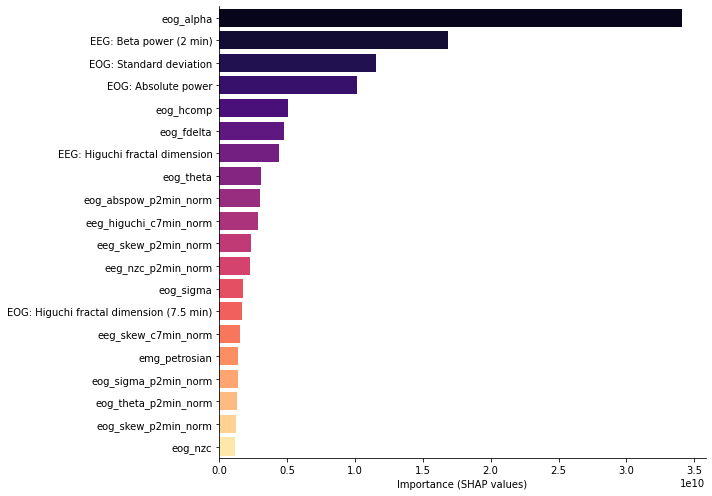

In [20]:
fimp = 'output/classifiers/clf_%s_lgb_gbdt.csv' % model
df_fimp = pd.read_csv(fimp).head(20)
df_fimp['Features'] = df_fimp['Features'].replace(dic_features)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.barplot(data=df_fimp, y="Features", x="Importance", palette="magma", saturation=1)

plt.ylabel("")
plt.xlabel("Importance (SHAP values)")
sns.despine()
plt.tight_layout()
plt.show()#.savefig(outdir + "cv_fimp.png", dpi=300, bbox_inches="tight")

In [22]:
df_fimp

,Features,Importance
0,eog_alpha,3.413817e+10
1,EEG: Beta power (2 min),1.683538e+10
2,EOG: Standard deviation,1.151032e+10
3,EOG: Absolute power,1.012206e+10
4,eog_hcomp,5.019551e+09
5,eog_fdelta,4.742362e+09
6,EEG: Higuchi fractal dimension,4.423428e+09
7,eog_theta,3.053526e+09
8,eog_abspow_p2min_norm,2.966994e+09
9,eeg_higuchi_c7min_norm,2.840810e+09
